In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import vmap
from jax import jit, lax, grad
import matplotlib.pyplot as plt
import cmocean as cmo
import importlib

from jax.config import config
config.update("jax_enable_x64", True)

In [22]:
from stopro.data_generator.sinusoidal import Sinusoidal
from stopro.data_generator.sin_1D_naive import Sin1DNaive
from stopro.data_generator.sin_1D import Sin1D
from stopro.data_preparer.data_preparer import DataPreparer
from stopro.sub_modules.load_modules import load_params, load_data
from stopro.sub_modules.loss_modules import hessian, logposterior
from stopro.sub_modules.init_modules import get_init, reshape_init
import stopro.GP.gp_sinusoidal_independent as gp_sinusoidal_independent
import stopro.GP.gp_naive as gp_1D_naive
from stopro.data_handler.data_handle_module import HdfOperator
from stopro.GP.kernels import define_kernel
from stopro.solver.optimizers import optimize_by_adam
import stopro.GP.gp_1D_laplacian as gp_1D_laplasian

In [23]:
## import modules
import bbmm.utils.preconditioner as precond
import bbmm.utils.conjugate_gradient as cg
import bbmm.functions.pivoted_cholesky as pc
import bbmm.utils.calc_logdet as calc_logdet
import bbmm.utils.calc_trace as calc_trace
import bbmm.operators.dense_linear_operator as dense_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
import bbmm.operators.diag_linear_operator as diag_linear_operator
import bbmm.operators._linear_operator as _linear_operator
import bbmm.operators.psd_sum_linear_operator as psd_sum_linear_operator
import bbmm.operators.root_linear_operator as root_linear_operator
from bbmm.functions.pivoted_cholesky_numpy import pivoted_cholesky_numpy
def reload():
    importlib.reload(precond)
    importlib.reload(cg)
    importlib.reload(pc)
    importlib.reload(calc_logdet)
    importlib.reload(calc_trace)
    importlib.reload(dense_linear_operator)
    importlib.reload(root_linear_operator)
    importlib.reload(diag_linear_operator)
    importlib.reload(_linear_operator)
    importlib.reload(psd_sum_linear_operator)
    importlib.reload(root_linear_operator)
    importlib.reload(gp_1D_laplasian)
reload()

In [28]:
def is_positive_definite(matrix):
    # 行列の固有値を計算
    eigenvalues = np.linalg.eigvals(matrix)

    # 全ての固有値が正であるかをチェック
    if np.all(eigenvalues > 0):
        return True
    else:
        return False

In [14]:
project_name = 'data'
simulation_name = 'test_sin1d'

In [15]:
data_preparer = DataPreparer(
    project_name, simulation_name, class_data_generator=Sin1D)
data_preparer.load_params(
    system_name="sin_1D", use_existing_params=False
)
# data_preparer.params_generate_training[''] = 1000

data_preparer.create_directory()

data_preparer.make_data()
data_preparer.save_params_prepare()
data_preparer.save_params_main()
data_preparer.save_lbls()

In [16]:
params_main, params_prepare, lbls = load_params(f"{project_name}/{simulation_name}/data_input")
params_model = params_main["model"]
params_optimization = params_main["optimization"]
params_plot = params_prepare["plot"]
vnames = params_prepare["vnames"]
params_setting = params_prepare["setting"]
params_generate_training = params_prepare["generate_training"]
params_generate_test = params_prepare["generate_test"]
params_kernel_arg = params_prepare["kernel_arg"]

# prepare initial hyper-parameter
init = get_init(
    params_model["init_kernel_hyperparameter"],
    params_model["kernel_type"],
    system_type=params_model["system_type"],
)

In [17]:
# prepare data
hdf_operator = HdfOperator(f"{project_name}/{simulation_name}")
r_test, μ_test, r_train, μ_train, f_train = load_data(lbls, vnames, hdf_operator)
delta_y_train = jnp.empty(0)
for i in range(len(r_train)):
    delta_y_train = jnp.append(delta_y_train, f_train[i] - μ_train[i])

params_model["epsilon"] = 1e-06
args_predict = r_test, μ_test, r_train, delta_y_train, params_model["epsilon"]
noise = params_model["epsilon"]

In [18]:
r_test, f_test = hdf_operator.load_test_data(lbls['test'], vnames['test'])

In [26]:
# setup model
Kernel = define_kernel(params_model)
gp_model = gp_1D_laplasian.GPmodel1DLaplacian(
    Kernel=Kernel,
)
gp_model.set_constants(*args_predict)
loglikelihood, predictor = (
    gp_model.trainingFunction_all,
    gp_model.predictingFunction_all,
)
func = jit(logposterior(loglikelihood, params_optimization))
dfunc = jit(grad(func, 0))
hess = hessian(func)

In [66]:
K = gp_model.trainingK_all(init, r_train)
K = gp_model.add_eps_to_sigma(K, noise)
is_positive_definite(K), jnp.linalg.cond(K)

(True, Array(104.55210545, dtype=float64))

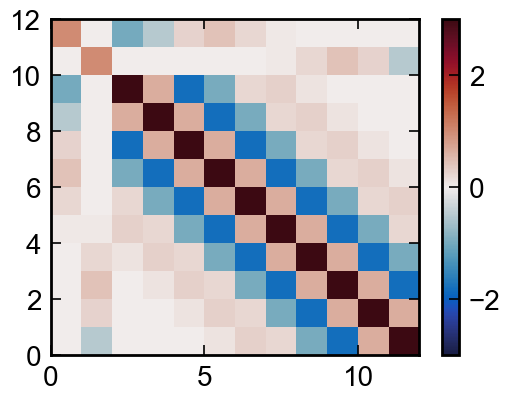

In [67]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(np.flipud(K), vmin=-np.max(K), vmax=np.max(K), cmap=cmo.cm.balance)
fig.colorbar(mappable)

In [30]:
def setup_loss_mpcg(rank=15, n_tridiag=10, seed=0, tolerance=0.01, max_tridiag_iter=20):
    def loss_mpcg(init, *args):

        r, delta_y, noise = args

        K = gp_model.trainingK_all(init, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)

        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
        if precondition:
            zs = precond_lt.zero_mean_mvn_samples(n_tridiag, seed=0)
        else:
            zs = jax.random.normal(jax.random.PRNGKey(0), (len(delta_y), n_tridiag))
        # zs_norms = jnp.linalg.norm(zs, axis=0, keepdims=True)
        # zs = zs/zs_norms
        rhs = jnp.concatenate([zs, delta_y.reshape(-1, 1)], axis=1)

        Kinvy, j,t_mat = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=n_tridiag, 
            max_tridiag_iter=max_tridiag_iter
        )

        logdet = calc_logdet.calc_logdet(K.shape, t_mat, precond_logdet_cache)

        yKy = jnp.dot(delta_y, Kinvy[:, -1])
        loss = (yKy + logdet)/2 + len(delta_y)/2*jnp.log(jnp.pi*2)    
        # print(yKy)
        # print(logdet)
        return loss
    return loss_mpcg

In [31]:
loglikelihood_mpcg = setup_loss_mpcg(rank=5, n_tridiag=10, max_tridiag_iter=20, tolerance=1)

In [32]:
func_mpcg = logposterior(loglikelihood_mpcg, params_optimization)
dfunc_mpcg = jit(grad(func_mpcg, 0))
hess_mpcg= hessian(func_mpcg)

In [33]:
params_optimization["maxiter_scipy"] = [0]
params_optimization["maxiter_GD"] = 5

In [34]:
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: 1.1445494737310344
step   0 loss: 1.1445 max_grad: 2.40873, arg=1
norm_of_grads: 2.45149
[-0.01  0.01]
step   1 loss: 1.1158 max_grad: 2.44004, arg=1
norm_of_grads: 2.48182
[-0.02  0.02]
step   2 loss: 1.0867 max_grad: 2.47120, arg=1
norm_of_grads: 2.51200
[-0.03  0.03]
step   3 loss: 1.0573 max_grad: 2.50219, arg=1
norm_of_grads: 2.54203
[-0.04  0.04]
step   4 loss: 1.0276 max_grad: 2.53300, arg=1
norm_of_grads: 2.57190
[-0.05    0.0501]


In [35]:
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
)

loss before optimize: 1.0816671092211159
step   0 loss: 1.0817 max_grad: 2.60667, arg=1
norm_of_grads: 2.64624
[-0.01  0.01]
step   1 loss: 1.0509 max_grad: 2.63777, arg=1
norm_of_grads: 2.67647
[-0.02  0.02]
step   2 loss: 1.0198 max_grad: 2.66859, arg=1
norm_of_grads: 2.70642
[-0.03  0.03]
step   3 loss: 0.9885 max_grad: 2.69912, arg=1
norm_of_grads: 2.73610
[-0.04  0.04]
step   4 loss: 0.9568 max_grad: 2.72936, arg=1
norm_of_grads: 2.76550
[-0.05  0.05]


## check if we can reach convergence

In [36]:
params_optimization

{'eps': 1e-05,
 'index_fixed': None,
 'interval_check': None,
 'loss_ridge_regression': False,
 'lr': 0.01,
 'maxiter_GD': 5,
 'maxiter_scipy': [0],
 'method_GD': 'adam',
 'method_scipy': ['Nelder-Mead'],
 'print_process': True}

In [37]:
params_optimization["maxiter_GD"] = 1000
params_optimization["print_process"] = False

In [38]:
opts = [{"x": init}]
opt, loss, theta, norm_of_grads_list = optimize_by_adam(
    func, dfunc, hess, init, params_optimization, *args_predict[2:]
)

loss before optimize: 1.1445494737310344
converged


In [39]:
len(norm_of_grads_list)

566

In [40]:
len(loss)

567

In [54]:
params_optimization["maxiter_GD"] = 566
params_optimization["print_process"] = False
opts = [{"x": init}]
opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimize_by_adam(
    func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
)

loss before optimize: 1.0816671092211159


In [55]:
len(loss_mpcg)

567

In [56]:
# params_optimization["maxiter_GD"] = 73
# params_optimization["print_process"] = False
# opts = [{"x": init}]
# opt_mpcg, loss_mpcg, theta_mpcg, norm_of_grads_list_mpcg = optimize_by_adam(
#     func_mpcg, dfunc_mpcg, hess_mpcg, init, params_optimization, *args_predict[2:]
# )
## diverged

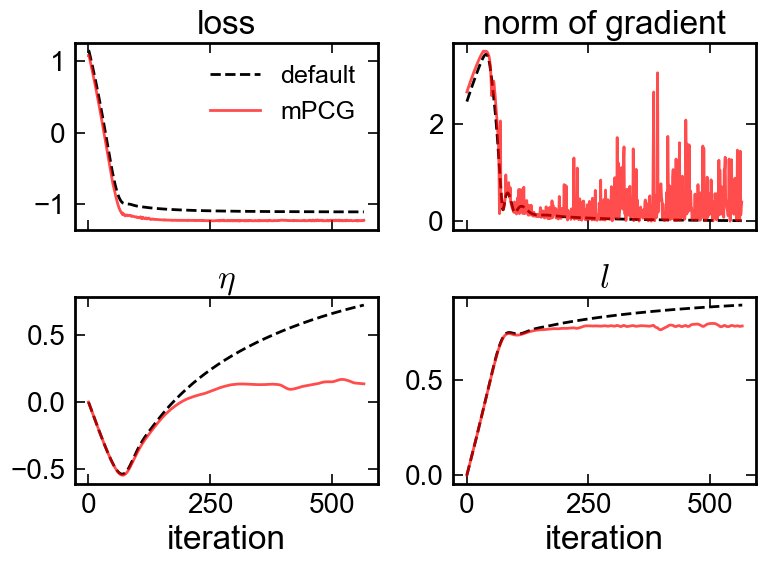

In [57]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), sharex=True)
kwargs = {"linestyle": "--"}
kwargs_mpcg = {"alpha": 0.7}

axs[0][0].plot(loss, **kwargs, label='default')
axs[0][0].plot(loss_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][0].set_title('loss')

axs[0][1].plot(norm_of_grads_list, **kwargs, label='default')
axs[0][1].plot(norm_of_grads_list_mpcg, label='mPCG', **kwargs_mpcg)
axs[0][1].set_title('norm of gradient')

                    
axs[1][0].plot(np.array(theta)[:, 0], **kwargs)
axs[1][0].plot(np.array(theta_mpcg)[:, 0], **kwargs_mpcg)
axs[1][0].set_title('$\eta$')
axs[1][0].set_xlabel('iteration')

axs[1][1].plot(np.array(theta)[:, 1], **kwargs)
axs[1][1].plot(np.array(theta_mpcg)[:, 1], **kwargs_mpcg)
axs[1][1].set_title('$l$')
axs[1][1].set_xlabel('iteration')

axs[0][0].legend()
plt.tight_layout()

In [58]:
def setup_predictor_mpcg(rank=15, n_tridiag=10, seed=0, tolerance=0.001, max_tridiag_iter=20, max_iter_cg=1000):
    def predictor_mpcg(opt, *args):

        r_test, μ_test, r, delta_y, noise = args

        K = gp_model.trainingK_all(opt, r)
        K = gp_model.add_eps_to_sigma(K, noise, noise_parameter=None)
        
        Kab = gp_model.mixedK_all(opt, r_test, r_train)
        Kaa = gp_model.testK_all(opt, r_test)

        precondition, precond_lt, precond_logdet_cache = precond.setup_preconditioner(K, rank=rank, noise=noise)
        rhs = jnp.concatenate([delta_y.reshape(-1, 1)], axis=1)

        Kinvy, j = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=0, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )
        
        rhs = Kab.T

        Kinvk, j = cg.mpcg_bbmm(
            K,
            rhs,
            precondition=precondition, 
            print_process=False, 
            tolerance=tolerance, 
            n_tridiag=0, 
            max_tridiag_iter=max_tridiag_iter,
            max_iter_cg=max_iter_cg
        )


        kKy = jnp.matmul(Kab, Kinvy)
        kKk = jnp.matmul(Kab, Kinvk)
        print(kKy.shape)
        f_infer_mpcg = [μ_test[0] + jnp.squeeze(kKy, axis=1)]
        Sigma_mpcg = Kaa - kKk
        # print(yKy)
        # print(logdet)
        return f_infer_mpcg, Sigma_mpcg
    return predictor_mpcg

In [59]:
predictor_mpcg = setup_predictor_mpcg()
f_infer_mpcg, Sigma_mpcg = predictor_mpcg(opt_mpcg, *args_predict)
std_mpcg = jnp.sqrt(jnp.diag(Sigma_mpcg))

(300, 1)


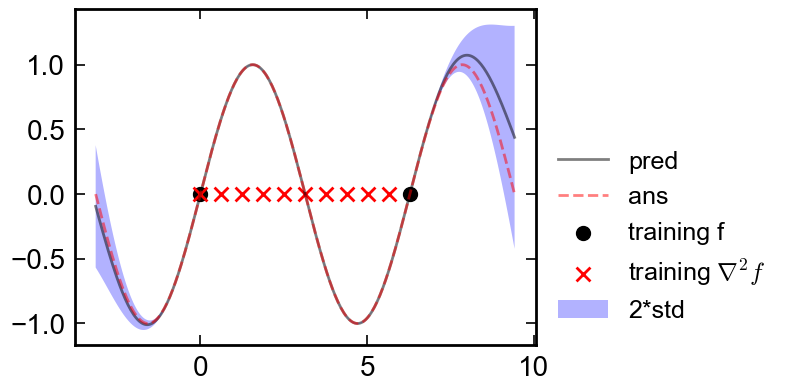

In [60]:
fs, Σs = predictor(opt, *args_predict)
std = np.sqrt(np.diag(Σs[0]))
fig, ax = plt.subplots()
ax.plot(r_test[0], fs[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
ax.scatter(r_train[0], f_train[0], label='training f')
ax.scatter(r_train[1], np.zeros_like(f_train[1]), label=r'training $\nabla^2f$', marker='x')
ax.fill_between(r_test[0], fs[0]-std*2, fs[0]+std*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))

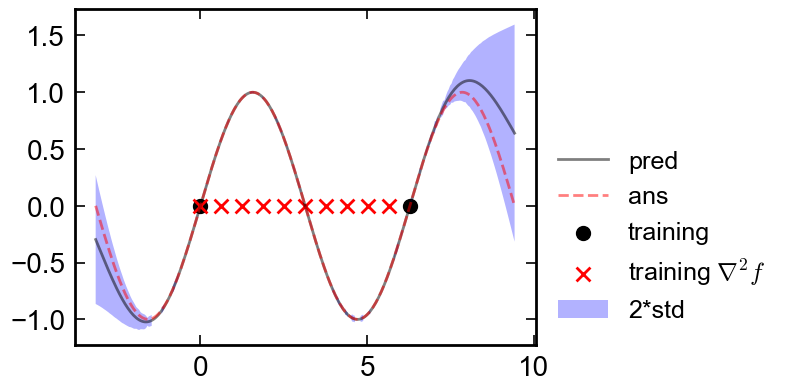

In [61]:
fig, ax = plt.subplots()
ax.plot(r_test[0], f_infer_mpcg[0], alpha=0.5, label='pred')
ax.plot(r_test[0], f_test[0], alpha=0.5, linestyle='--', label='ans')
ax.scatter(r_train[0], f_train[0], label='training')
ax.scatter(r_train[1], np.zeros_like(f_train[1]), label=r'training $\nabla^2f$', marker='x')
ax.fill_between(r_test[0], f_infer_mpcg[0]-std_mpcg*2, f_infer_mpcg[0]+std_mpcg*2, alpha=0.3, label='2*std')
ax.legend(loc='lower left', bbox_to_anchor=(1., 0.))
plt.show()

In [62]:
index_check = (0 <= r_test[0]) & (r_test[0] <= 2*np.pi)

In [63]:
np.mean(np.abs(fs[0][index_check]-f_test[0][index_check])), np.mean(np.abs(f_infer_mpcg[0][index_check]-f_test[0][index_check]))

(0.00018446334476069447, 0.0005668251076772283)

In [64]:
np.exp(opt), np.exp(opt_mpcg)

(array([2.07145351, 2.44960342]), array([1.14683018, 2.19386859]))